In [8]:
from pronto import Ontology,xref
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
from urllib.parse import quote
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint
import pickle
import sys
import importlib

import pandas as pd
from collections import defaultdict


# Load LSFC 


In [4]:
import warnings
warnings.filterwarnings("ignore")
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"//utils")

import retrieve_LSFC

import importlib
# reload if library gets updated
importlib.reload(retrieve_LSFC)

### Load LSFC 

LSFC_file='../../LSFC/LSFC/LSFC.obo'
id_to_name,name_to_id,id_to_synonyms,id_2_childs,id_2_parents=retrieve_LSFC.read_LSFC(LSFC_file)
# Get names of 9 main LSF catgeories
LSF_exisiting_names, LSF_Labels,LFIDs,categories=retrieve_LSFC.generate_lfid_categories_labels(LSFC_file)



# General functions

In [6]:

def make_query(term):
    #term='"'+term+'"'
    return quote(term)
import urllib.request, urllib.error, urllib.parse
import json
import os
from pprint import pprint

REST_URL = "http://data.bioontology.org"
API_KEY = "" 



def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())



# Read list of 50 manually shortlisted ontologies
    * This is the final list of selected ontologies which are shortlisted by src/Xrefs/1-Ontology-selection.ipynb and then manually corrected

In [11]:
ontologies=pd.read_csv('../../data/xref/50_Selected Ontologies.tsv',sep='\t')
ontologies.head()

,acronym,ontology_name,acceptance_score,match_count,coverage,names,class_counts,number_of_releases,first_release_year,last_release_year,overlap,covergae_rank,overlap_rank,rank,url
0,PCALION,Prostate Cancer Lifestyle Ontology,183.00,21.0,0.043299,income#dairy product#education#vitamin#egg#fru...,397.0,6.0,2019.0,2020.0,0.052897,13.0,1.0,1.0,https://bioportal.bioontology.org/ontologies/P...
1,MESH,Medical Subject Headings,887.00,138.0,0.284536,recreational drug#delta sleep#household activi...,349665.0,25.0,2009.0,2022.0,0.000395,1.0,38.0,1.0,https://bioportal.bioontology.org/ontologies/MESH
2,DILON,Dietary lifestyle ontology,0.19,11.0,0.022680,vitamin#meat#egg#malnutrition#legume#fruit#bev...,262.0,2.0,2021.0,2021.0,0.041985,24.0,2.0,2.0,https://bioportal.bioontology.org/ontologies/D...
3,MDM,Mapping of Drug Names and MeSH 2022,277.00,132.0,0.272165,recreational drug#delta sleep#household activi...,44789.0,5.0,2021.0,2022.0,0.002947,2.0,18.0,2.0,https://bioportal.bioontology.org/ontologies/MDM
4,EXMO,Exercise Medicine Ontology,0.00,11.0,0.022680,physical fitness#athlete#anaerobic exercise#sl...,407.0,2.0,2022.0,2022.0,0.027027,23.0,3.0,3.0,https://bioportal.bioontology.org/ontologies/EXMO


In [12]:
selected_ontologies=','.join(list(ontologies.acronym))

# Search for overlapping names in target ontologies

In [13]:
#dict_ontology_to_annotated_all_names=defaultdict(list)

columns = ['name','LFID', 'ontology_acronym', 'xref_id', 'xref_definition']
annotations = pd.DataFrame(columns=columns)

for i,name in tqdm(enumerate(LSF_exisiting_names)):
    results=get_json('https://data.bioontology.org/search?q=' + make_query(name)+'&pagesize=500&ontologies='+selected_ontologies+'&include_properties=TRUE&include_views=TRUE&includeObsolete=FALSE&require_definition=false&exact_match=true&categories=&suggest=TRUE')
    LFID=LFIDs[i]
    for result in results['collection']:
        ontology_acronym=result['links']['ontology'].split('https://data.bioontology.org/ontologies/')[1]   
        if 'definition' in result :
            definition_column = result['definition']
            xref_definition = definition_column[0]
        else:
            xref_definition=''
        #dict_ontology_to_annotated_all_names[ontology_acronym].append(name)

        row_data={'name':name, 'LFID':LFID, 'ontology_acronym':ontology_acronym, 'xref_id': result['@id'], 'xref_definition':xref_definition}

        annotations = annotations.append(row_data, ignore_index=True)


7324it [2:26:36,  1.20s/it]


In [14]:
annotations.shape

(9006, 5)

In [15]:
annotations.to_csv('../../data/xref/Xrefs_annotated_names_Jan_2014.tsv',sep='\t',index=None)


# Add Xrefs to LSFC

In [68]:
from pronto import Ontology,xref
from pronto.xref import Xref

LSFC_file='../../LSFC/LSFC/LSFC.obo'

LSFC = Ontology(LSFC_file)


for i, row in annotations.iterrows():
    LFID=row['LFID']
    x_ref=Xref(id=row['xref_id'],description=row['xref_definition'])
    LSFC._terms.entities[LFID].xrefs.add(x_ref)
 


# Save to LSFC

In [70]:

with open(LSFC_file, "wb") as f:
    LSFC.dump(f, format="obo")


In [17]:
annotations.head()

,name,LFID,ontology_acronym,xref_id,xref_definition
0,nutrition,LFID:0000003,LOINC,http://purl.bioontology.org/ontology/LNC/MTHU0...,
1,nutrition,LFID:0000003,LOINC,http://purl.bioontology.org/ontology/LNC/LP172...,
2,nutrition,LFID:0000003,SNOMEDCT,http://purl.bioontology.org/ontology/SNOMEDCT/...,
3,nutrition,LFID:0000003,MEDLINEPLUS,http://purl.bioontology.org/ontology/MEDLINEPL...,<p>Food provides the energy and nutrients you ...
4,nutrition,LFID:0000003,CRISP,http://purl.bioontology.org/ontology/CSP/2116-...,"science of food, the nutrients and other subst..."


# Visualization

In [18]:
grouped_df = annotations.groupby('ontology_acronym').size().reset_index(name='counts')
grouped_df=grouped_df.sort_values(by='counts',ascending=False)
df=grouped_df.iloc[:20]

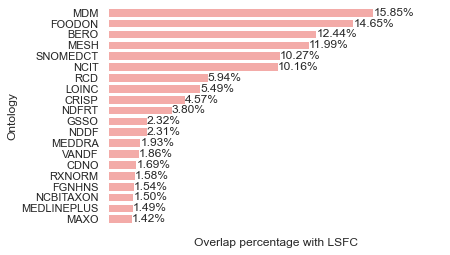

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming LSFC_size is the total size you want to use for percentage calculation
# Replace LSFC_size with the actual value or variable that contains the total size

# Calculate percentage
df['percentage'] = (df['counts'] / LSFC_size) * 100

sns.set_theme(style="white")

# Initialize the matplotlib figure
# f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
ax = sns.barplot(x="percentage", y="ontology_acronym", data=df, label="", color="r")

container = ax.containers[0]
# Label the bars with percentage values
ax.bar_label(container, labels=[f'{x:,.2f}%' for x in container.datavalues])

# Remove x-axis labels (if desired)
ax.set(xticklabels=[])

# Set axis labels and limits
ax.set(xlim=(0, 20), ylabel="Ontology", xlabel="Overlap percentage with LSFC")
sns.despine(left=True, bottom=True)

# Save the plot
plt.savefig('../../plots/Xrefs_ontology_overlaps_with_LSFC_percentage.png',bbox_inches="tight", dpi=300)
